# Final project
## Task 1. A/B testing
### Condition

One of the main tasks of the analyst in our team is the correct conduct of experiments. To do this, we use the A/B testing method. During testing of one hypothesis, the target group was offered a new mechanism for paying for services on the site, while the control group retained the basic mechanics. As a task, you need to analyze the results of the experiment and decide whether it is worth launching a new payment mechanism for all users.

###  Input data

You have 4 csv files as input:


- **groups.csv** - file with information about the user's belonging to the control or experimental group (A - control, B - target group)
- **groups_add.csv** - an additional file with users that was sent to you 2 days after the data transfer
- **active_studs.csv** - a file with information about users who logged into the platform on the days of the experiment.
- **checks.csv** - file with information about user payments on the days of the experiment.
### Questions

We invite you to answer the following questions:

- What metrics do you look at during the analysis and why?
- Are there differences in performance and what might they be related to?
- Are these differences statistically significant?
- Is it worth launching new mechanics for all users?

# Task 2. SQL
## 2.1 Very diligent students.

### 2.1.1. Condition

Educational courses consist of various lessons, each of which consists of several small tasks. Each such small task is called a "pea".

Let's call a very diligent student a user who correctly solved 20 peas at least once during the current month.
### 2.1.2 Task
Given a **default.peas** table:

| Attribute name | Attribute type | Semantic meaning |
| ------ | ------ | ------ |
| st_id | int | Student ID |
| timest | timestamp | Time decision card |
| correct| bool | Is the pea solved correctly? |
| subject | text | The discipline in which the pea is located |

It is necessary to write an optimal query that will give information about the number of very diligent students.

NB! By a very diligent student, we mean a student who correctly solved 20 problems in the current month.

## 2.2 Funnel optimization

### 2.2.1 Condition

The educational platform offers students to take courses according to the trial model: a student can solve only 30 peas a day for free. For an unlimited number of tasks in a particular discipline, the student must purchase full access. The team ran an experiment where they tested the new payment screen.

### 2.2.2 Task

Table given: **default.peas** (see above), **default.studs**:

| Attribute name | Attribute type | Semantic meaning |
| ------ | ------ | ------ |
| st_id | int | Student ID |
| test_grp | text | Student label in this experiment |

and **default.final_project_check**:

| Attribute name | Attribute type | Semantic meaning |
| ------ | ------ | ------ |
| st_id | int | Student ID |
| sale_time | timestamp | Shopping time |
| money | int | The price at which this course was purchased |
| subject | text | Discipline purchased with full access |

It is necessary to upload the following information about user groups in one request:

-ARPU
- ARPAU
- CR in purchase
- CR of an active user in a purchase
- User CR from math activity (subject = 'math') to math course purchase

ARPU is calculated relative to all users in groups.

**Active** is a user who has solved more than 10 problems correctly in all disciplines.

**Active in math** is a user who has solved 2 or more problems correctly in math for the entire time.
NB: All data is tabular in Clickhouse

# Task 3. Python
## 3.1 Task

Implement a function that will automatically load information from an additional file **groups_add.csv** (headers may differ) and recalculate metrics based on additional parameters.
Implement a function that will build graphs based on the received metrics.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
import datetime as dt
%matplotlib inline 
import calendar
from tqdm.auto import tqdm
from scipy.stats import norm 
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro, levene, chi2_contingency
import statsmodels.api as sm
from datetime import datetime
import pandahouse as ph
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pingouin as pg

from scipy import stats
from scipy.stats import norm
import pingouin as pg

# Task 1. A/B testing

In [2]:
# file with information about the user's belonging to the control or experimental group (A - control, B - target group) 
groups = pd.read_csv('groups.csv', sep=';')
# additional file with users that was sent to you 2 days after the data transfer
group_add = pd.read_csv('group_add.csv')
# file with information about users who logged into the platform on the days of the experiment
active_studs = pd.read_csv('active_studs.csv', sep=';')
# file with information about user payments on the days of the experiment
checks = pd.read_csv('checks.csv', sep=';')

In [3]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)

checks.rename(columns={'student_id': 'id'}, inplace=True)

### table: groups

In [5]:
print('Number of lines:', groups.shape[0],'\n')
print('Number of null id values:', groups.id.isna().sum(),'\n')
print('Number of null values ​​grp:', groups.grp.isna().sum(),'\n')
print('Unique id in dataset:', groups.id.nunique(),'\n')

if groups.shape[0] == groups.id.nunique():
    print('Note: All id values ​​are unique')
else:
    print('Note: Beware of duplicates')

Number of lines: 74484 

Number of null id values: 0 

Number of null values ​​grp: 0 

Unique id in dataset: 74484 

Note: All id values ​​are unique


### table: group_add

In [6]:
print('Number of rows:', group_add.shape[0],'\n')
print('Number of null id values:', group_add.id.isna().sum(),'\n')
print('Number of null values ​​grp:', group_add.grp.isna().sum(), '\n')
print('Unique id in dataset:', group_add.id.nunique(),'\n')

if group_add.shape[0] == group_add.id.nunique():
    print('Note: All id values ​​are unique')
else:
    print('Note: Beware of duplicates')

Number of rows: 92 

Number of null id values: 0 

Number of null values ​​grp: 0 

Unique id in dataset: 92 

Note: All id values ​​are unique



#### Join tables groups, group_add

In [7]:
general = pd.concat([groups, group_add])

In [8]:
print('Number of lines:', general.shape[0],'\n')
print('Number of null id values:', general.id.isna().sum(),'\n')
print('Number of null values ​​grp:', general.grp.isna().sum(),'\n')
print('Unique id in dataset:', general.id.nunique(),'\n')

if general.shape[0] == general.id.nunique():
    print('Note: All id values ​​are unique')
else:
    print('Note: Beware of duplicates')

Number of lines: 74576 

Number of null id values: 0 

Number of null values ​​grp: 0 

Unique id in dataset: 74576 

Note: All id values ​​are unique


In [9]:
print('The number of rows was:', group_add.id.count() + groups.id.count(),
      '\nNumber of rows after join:', pd.concat([groups, group_add]).id.count())
if (group_add.id.count() + groups.id.count()) == general.id.count():
    print('Correct')
else:
    print('ERROR')

The number of rows was: 74576 
Number of rows after join: 74576
Correct


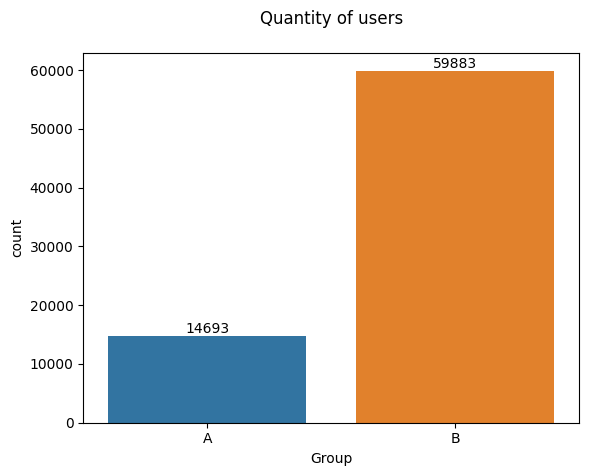

In [10]:
ax = sns.countplot(x = general['grp'].sort_values())
ax.set_title('Quantity of users\n')
ax.set_xlabel('Group')

for container in ax.containers:
    ax.bar_label(container)

In [11]:
# Calculate the percentage of people in groups.
general.grp.value_counts(normalize=True).mul(100).round(2)

B    80.3
A    19.7
Name: grp, dtype: float64

In the control group (A) 14693 people ~ **19.7%**, in the test group (B) - 59883 people ~ **80.3%**.

 The resulting group distribution looks a little strange

#### table: active_studs

In [83]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
print('Number of lines:', active_studs.shape[0],'\n')
print('Unique ids in the dataset:', active_studs.id.nunique(),'\n')

Number of lines: 8341 

Unique ids in the dataset: 8341 



do all id from active_studs appear in general

In [14]:
active_studs.id.isin(general.id).value_counts()

True    8341
Name: id, dtype: int64

#### table: checks

In [15]:
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
print('Number of lines:', checks.shape[0],'\n')
print('Number of missing id values:', checks.id.isna().sum(),'\n')
print('Number of missing values ​​rev:', checks.rev.isna().sum(),'\n')
print('Unique id in dataset:', checks.id.nunique(),'\n')
print('Unique id duplicates in dataset:', checks.id.duplicated().sum(),'\n')

Number of lines: 541 

Number of missing id values: 0 

Number of missing values ​​rev: 0 

Unique id in dataset: 541 

Unique id duplicates in dataset: 0 




There are no null values ​​or duplicates. A total of 541 payments, each user made one purchase.
Let's check whether all users who made the payment logged into the platform on the days of the experiment.

In [88]:
checks.id.isin(active_studs.id).value_counts()

True     392
False    149
Name: id, dtype: int64

149 users made a payment, but did not enter the platform. Perhaps this is connected to auto payments, there was an automatic write-off of money and the user did not visit the site. I will not take into account user data in the future.

In [17]:
checks.id.isin(general.id).value_counts()

True    541
Name: id, dtype: int64

Let's merge the tables, excluding users who paid, but did not enter the platform on the days of the experiment

In [18]:
df = general.merge(checks, on='id', how='left').fillna(0)
df.head(2)

,id,grp,rev
0,1489,B,0.0
1,1627,A,990.0


In [19]:
df['is_active'] = df.id.isin(active_studs.id)
df.head(3)

,id,grp,rev,is_active
0,1489,B,0.0,False
1,1627,A,990.0,True
2,1768,B,0.0,False


In [20]:
df_active = df[(df.is_active)]

In [21]:
df_active['paid'] = (df_active.rev != 0) * 1

In [22]:
df_active

,id,grp,rev,is_active,paid
1,1627,A,990.0,True,1
10,2085,B,0.0,True,0
12,2215,B,0.0,True,0
43,3391,A,0.0,True,0
45,3401,B,0.0,True,0
...,...,...,...,...,...
74543,5760471,B,0.0,True,0
74545,5777081,B,0.0,True,0
74558,5870856,A,0.0,True,0
74561,5945085,B,0.0,True,0


In [23]:
df_active.drop('is_active', inplace=True, axis=1)
df_active.head()

,id,grp,rev,paid
1,1627,A,990.0,1
10,2085,B,0.0,0
12,2215,B,0.0,0
43,3391,A,0.0,0
45,3401,B,0.0,0


In [24]:
df_1 = df_active \
    .groupby('grp', as_index = False)\
    .agg({'rev':'mean', 
          'paid':'mean', 
          'id':'count'})\
    .rename(columns={'rev': 'avg_rev',
                     'paid':'avg_paid',
                     'id':'count_id'})
df_1.head(2)

,grp,avg_rev,avg_paid,count_id
0,A,47.347204,0.050715,1538
1,B,58.058798,0.046156,6803


## Metrics

**CR** - the ratio of the number of paid customers to the number of those who visited the application.
will help to understand where it is easier and more comfortable for the client to make a payment

**ARPU** - the ratio of the total amount of payments to the number of users who entered the application.

**ARPPU** - the ratio of the total amount of payments to the number of active paying users.


### Conversion (CR)

In [25]:
# Calculate the conversion for two groups
df_active\
    .groupby('grp', as_index=False) \
    .paid.mean() \
    .rename(columns={'paid': 'cr'})
# We see deterioration in the test group, compared with the control.

,grp,cr
0,A,0.050715
1,B,0.046156


<Axes: xlabel='paid', ylabel='Count'>

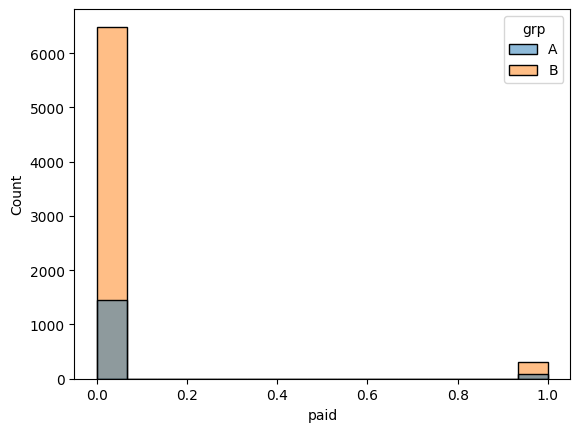

In [26]:
# We also visualize the distribution of conversions in groups
sns.histplot(x='paid',
             data=df_active[['grp','paid']],
             hue='grp')


In [28]:

# Abnormal distribution in groups A and B
pg.normality(data=df_active, dv='paid', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,1275.124182,1.289146e-277,False
B,5805.498194,0.000000e+00,False


### ARPU

In [29]:
a_group = df_active.query('grp == "A"')
b_group = df_active.query('grp == "B"')

In [30]:
a_descr = a_group.rev.describe().to_frame().rename(columns={'rev': 'Group A'})
b_descr = b_group.rev.describe().to_frame().rename(columns={'rev': 'Group B'})
pd.concat([a_descr, b_descr], axis=1)

,Group A,Group B
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


In [31]:
# Calculate ARPU for two groups. There is an improvement in the test group
df_active.groupby('grp', as_index=False).rev.mean().rename(columns={'rev': 'ARPU'})

,grp,ARPU
0,A,47.347204
1,B,58.058798


In [32]:
# Abnormal distribution in groups A and B
pg.normality(data=df_active, dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,2240.595797,0.0,False
B,7797.399212,0.0,False


### ARPPU

In [33]:
active_paid = df_active.query('rev > 0')
active_paid.head()

,id,grp,rev,paid
1,1627,A,990.0000,1
220,100300,B,990.0000,1
320,108270,B,290.0000,1
3779,264473,B,1900.0001,1
4187,274352,B,690.0000,1


In [34]:
a_group_paid = active_paid.query('grp == "A"')
b_group_paid = active_paid.query('grp == "B"')

In [35]:
a_paid_desc = a_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Group A'})
b_paid_desc = b_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Group B'})
pd.concat([a_paid_desc, b_paid_desc], axis=1)

,Group A,Group B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


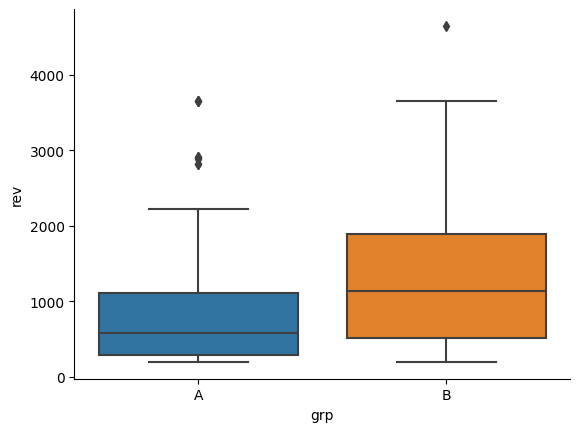

In [36]:
sns.boxplot(data=active_paid, y='rev', x='grp')
sns.despine()

Text(0.5, 0, 'Revenue')

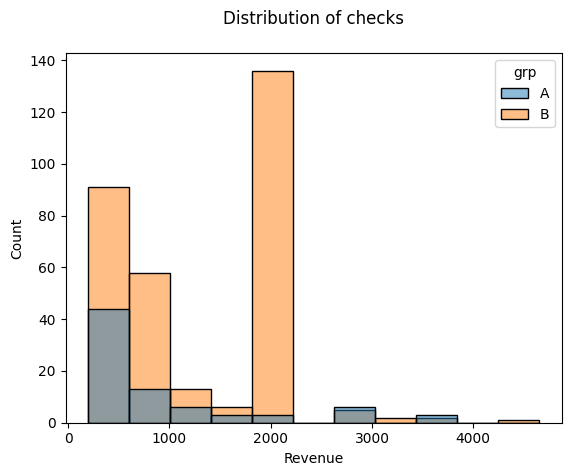

In [37]:
ax = sns.histplot(data = active_paid, x = 'rev', hue = 'grp')
ax.set_title('Distribution of checks\n')
ax.set_xlabel('Revenue')

In [38]:
# Abnormal distribution in groups A and B
pg.normality(data=active_paid, dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False



### Overview of metrics

Let's answer the question: Are there differences in the indicators and what can they be connected with?

In [39]:
metrics = df_active.groupby('grp', as_index = False)\
                    .agg({'id': 'count', 'paid': 'sum','rev': 'sum'})\
                    .rename(columns = {'id': 'users', 'paid': 'pay_users'})\
                    .assign(not_pay_users = lambda x: x.users - x.pay_users, \
                            arpu = lambda x:round((x.rev / x.users),2), \
                            arppu = lambda x: round((x.rev / x.pay_users),2),\
                            cr = lambda x: round((x.pay_users / x.users) * 100,2))
metrics
# in the third task, for convenience, we will use this fragment of code

,grp,users,pay_users,rev,not_pay_users,arpu,arppu,cr
0,A,1538,78,72820.0000,1460,47.35,933.59,5.07
1,B,6803,314,394974.0035,6489,58.06,1257.88,4.62


In [40]:

df = metrics[['arpu', 'arppu', 'cr']] # for further calculations, I will take only necessary columns
df
# 0 is A, 1 is B

,arpu,arppu,cr
0,47.35,933.59,5.07
1,58.06,1257.88,4.62


In [41]:

# answer the question is there a difference between group A and B
# difference of each metric, convert to percentage
# overwrite in a new table to make it look nice
diff_metrics = pd.DataFrame(round((-df.iloc[0] + df.iloc[1])/df.iloc[0]*100, 2)).T
diff_metrics

,arpu,arppu,cr
0,22.62,34.74,-8.88


1. conversion rate change(CR) -8.88%
2. change in revenue per user (ARPU) 22.62%
3. change in revenue per buyer (ARPU) 34.74%

Conversion drops, but revenue per user/buyer grows

### Tests

#### Note

Group sizes vary greatly. Plus the distributions in groups A and B are not normal (normality tests were done). I will use bootstrap.

1. bootstrap distribution for groups A and B.
2. Determination of their difference.
3. In the resulting distribution of the difference, we determine the confidence interval.
4. Whether the confidence interval falls into 0.


In [42]:
# bootstrap
def get_bootstrap(
    data_col_1, # numeric values ​​of the first sample
    data_col_2, # numeric values ​​of the second sample
    boot_iter = 2000, # number of bootstrap fetches
    statistic = np.mean, # statistics of interest
    bootstrap_conf_level = 0.95 # significance level
):
    boot_len = max(len(data_col_1), len(data_col_2))
    boot_data = []
    for i in range(boot_iter): # extract subsamples
        samples_1 = data_col_1.sample(
            boot_len,
            replace=True # return parameter
        ).values
        
        samples_2 = data_col_2.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data))
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data': boot_data,
            'ci': ci,
            'p_value': p_value}

### ARPU
(use bootstrap)


**Let's formulate the null and alternative hypotheses:**

 - **H0:** ARPUs in the two groups are the same.
 - **H1:** ARPU in the two groups are different.

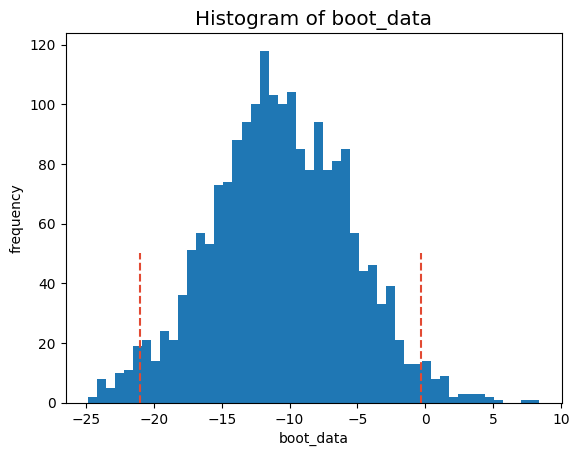

In [43]:
bootstrap_test_1 = get_bootstrap(a_group.rev, b_group.rev, boot_iter=2000)

In [44]:
bootstrap_test_1['ci']

,0
0.025,-21.055098
0.975,-0.348512


Zero is not included in the confidence interval - the differences are statistically significant

In [45]:
bootstrap_test_1['p_value']

0.038164807441046215

p-value < 0.05

- We reject the null hypothesis.

##### ARPU bootstrap output:
The mean values ​​in the test and control groups differ at the given level of significance, since the zero value of the difference between the two means does not fall within the 95 percent confidence interval.

p-value < 0.05: we have reason to reject the null hypothesis in favor of the alternative one.

ARPU in the two groups differ

### ARPPU

**Let's formulate the null and alternative hypotheses:**

 - **H0:** ARPPUs in the two groups are the same.
 - **H1:** ARPPU in the two groups are different.

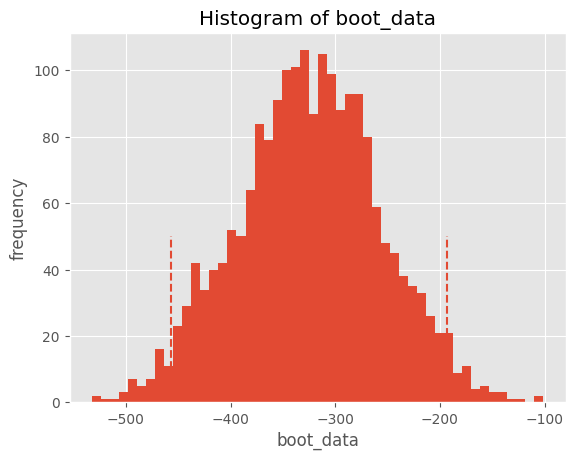

In [46]:
bootstrap_test_2 = get_bootstrap(a_group_paid.rev, b_group_paid.rev, boot_iter=2000)

In [47]:
bootstrap_test_2['ci']

,0
0.025,-457.062986
0.975,-193.610759


Zero is not included in the confidence interval - the differences are statistically significant

In [48]:
bootstrap_test_2['p_value']

1.8633225695433374e-06

p-value < 0.05
- We reject the null hypothesis.

##### Output (ARPPU):
ARPPUs in the test and control groups differ at a given level of significance because the zero difference between the two means does not fall within the 95% confidence interval.

p-value < 0.05 : allows us to state that the means in the two groups differ statistically significantly

### CR

Calculating conversion from site entry to purchase seems like a pretty reasonable metric to compare.

Of the previously obtained results in group B, the conversion was lower. Let's check the values ​​for statistical significance.
We use the chi-square test, since our variables are categorical.

 - **H0**: no relationship between variables
- **H1**: there is a relationship

In [49]:
# Let's look at the distribution of users who bought / did not buy in two groups A / B
df_active.groupby('grp').paid.value_counts()

grp  paid
A    0       1460
     1         78
B    0       6489
     1        314
Name: paid, dtype: int64

In [50]:
grp_a = df_active[df_active['grp'] == 'A']
grp_b = df_active[df_active['grp'] == 'B']

In [51]:
a_pay = grp_a.paid.sum()
a_no_pay = grp_a.paid.size - grp_a.paid.sum()
b_pay = grp_b.paid.sum()
b_no_pay = grp_b.paid.size - grp_b.paid.sum()

In [52]:
cr_matrix = np.array([[a_pay, a_no_pay],
                        [b_pay, b_no_pay]])

In [53]:
cr_matrix

array([[  78, 1460],
       [ 314, 6489]], dtype=int64)

In [54]:
# checking variances
pg.homoscedasticity(data=df_active, dv='paid', group='grp')

,W,pval,equal_var
levene,0.582052,0.445531,True


conversion data are essentially categorical values ​​(0 or 1), the best choice would be the Chi-squared test:
- observations are independent
- The number of observations in each cell is greater than 5

In [55]:
print(chi2_contingency(cr_matrix, correction=False))

Chi2ContingencyResult(statistic=0.5821513741106591, pvalue=0.44547028437158964, dof=1, expected_freq=array([[  72.28102146, 1465.71897854],
       [ 319.71897854, 6483.28102146]]))


**Conclusion:** p_value>0.05, do not reject the null hypothesis (the new mechanics does not affect the purchase decision)
(there is no known difference in conversions between the two groups)

### Bootstrap

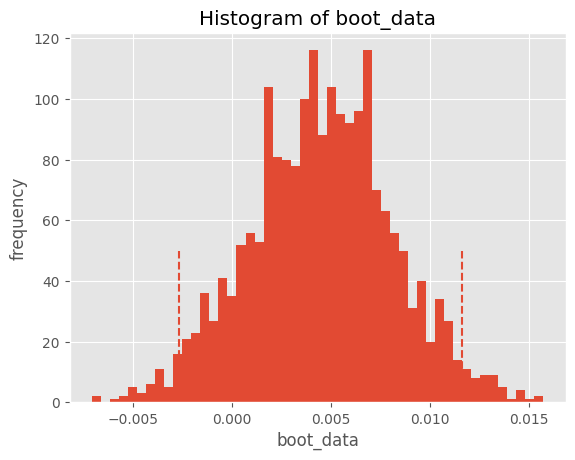

In [56]:
booted_data_cr = get_bootstrap(a_group.paid, b_group.paid, boot_iter=2000)

In [57]:
booted_data_cr['p_value']

0.20766436050720039

In [58]:
booted_data_cr['ci']

,0
0.025,-0.002646
0.975,0.011616


Дополнительно проведен бустрап.  0 - входит в ДИ. p-val > 0.05. Не отвергаем нулевую гипотезу. Различия между группами статистически незначимы

### Conclusion


Positive changes in ARPU and ARPPU, but negative changes in CR

After conducting statistical tests, it turned out that the deterioration in CR is statistically **not significant**, a positive change in ARPU, ARPPU is statistically significant.

As a result: we are rolling out a new payment mechanism for all users.

## Task 2. SQL

### 2.1 Very diligent students.

### 2.1.1. Condition

Educational courses consist of various lessons, each of which consists of several small tasks. Each such small task is called a "pea".

Let's call a very diligent student a user who correctly solved 20 peas at least once during the current month.
### 2.1.2 Task
Given a **default.peas** table:

| Attribute name | Attribute type | Semantic meaning |
| ------ | ------ | ------ |
| st_id | int | Student ID |
| timest | timestamp | Time decision card |
| correct| bool | Is the pea solved correctly? |
| subject | text | The discipline in which the pea is located |

It is necessary to write an optimal query that will give information about the number of very diligent students.

NB! By a very diligent student, we mean a student who correctly solved 20 problems in the current month.

In [59]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',  # set database connection parameters
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'
                      }

In [60]:
q = '''
SELECT st_id AS id,    
       SUM(correct) AS score       
    FROM default.peas  
    WHERE  
        toStartOfMonth(timest) == toStartOfMonth(now())  
    GROUP BY  
        st_id  
    HAVING
        SUM(correct) >= 20
'''
df = ph.read_clickhouse(query=q, connection=connection_default) 
df

,id,score


In [61]:
q_1 = '''
SELECT st_id, toDateTime(timest) as timest, correct, subject FROM default.peas
'''

In [62]:
df_1 = ph.read_clickhouse(query = q_1, connection = connection_default)
df_1.head()

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [63]:
df_1.timest.max()

Timestamp('2021-10-31 17:29:52')

In [64]:
df_1.timest.min()

Timestamp('2021-10-30 13:00:00')

In [65]:
q_res = '''
SELECT st_id AS id,    
       SUM(correct) AS score       
    FROM default.peas  
    GROUP BY  
        st_id  
    HAVING
        SUM(correct) >= 20
'''
df_res = ph.read_clickhouse(query=q_res, connection=connection_default) 
df_res.shape[0]

136

October 2021 data only Remove current month requirement

In [66]:
# but it's better to do it like this
q = '''
SELECT st_id AS id,    
       SUM(correct) AS score, toStartOfMonth(timest) AS month       
    FROM default.peas  
    WHERE  
        toStartOfMonth(timest) = MAX(toStartOfMonth(timest))  
    GROUP BY  
        st_id, month  
    HAVING
        SUM(correct) >= 20
'''
df = ph.read_clickhouse(query=q, connection=connection_default) 
df.shape[0]

136

## 2.2 Funnel optimization

### 2.2.1 Condition

The educational platform offers students to take courses according to the trial model: a student can solve only 30 peas a day for free. For an unlimited number of tasks in a particular discipline, the student must purchase full access. The team ran an experiment where they tested the new payment screen.

### 2.2.2 Task

Table given: **default.peas** (see above), **default.studs**:

| Attribute name | Attribute type | Semantic meaning |
| ------ | ------ | ------ |
| st_id | int | Student ID |
| test_grp | text | Student label in this experiment |

and **default.final_project_check**:

| Attribute name | Attribute type | Semantic meaning |
| ------ | ------ | ------ |
| st_id | int | Student ID |
| sale_time | timestamp | Shopping time |
| money | int | The price at which this course was purchased |
| subject | text | Discipline purchased with full access |

It is necessary to upload the following information about user groups in one request:

-ARPU
- ARPAU
- CR in purchase
- CR of an active user in a purchase
- User CR from math activity (subject = 'math') to math course purchase

ARPU is calculated relative to all users in groups.

**Active** is a user who has solved more than 10 problems correctly in all disciplines.

**Active in math** is a user who has solved 2 or more problems correctly in math for the entire time.
NB: All data is tabular in Clickhouse

In [67]:
q_2 = '''
with active_studs as (
  SELECT st_id,
           SUM(correct) AS active,
           SUMIf(correct, subject = 'Math') AS math_active
    FROM default.peas
    GROUP BY st_id
)

SELECT 
       test_grp,
       round(SUM(rev.money) / uniqExact(students.st_id), 2) as arpu,

       round(SUMIf(rev.money, active_studs.active > 10) / uniqExactIf(students.st_id, active_studs.active > 10), 2) AS arpau,

       round(uniqExactIf(students.st_id, rev.money > 0) / uniqExact(students.st_id), 2) AS cr,

       round(uniqExactIf(students.st_id, active_studs.active > 10 and rev.money > 0) / uniqExactIf(students.st_id, active_studs.active > 10), 2) AS cr_active,

       round(uniqExactIf(students.st_id, active_studs.math_active > 10 and rev.subject = 'Math' and rev.money > 0) / uniqExactIf(students.st_id, active_studs.math_active > 10), 2) AS cr_math

FROM default.studs AS students

FULL JOIN default.final_project_check AS rev
ON students.st_id = rev.st_id

FULL JOIN active_studs
ON students.st_id = active_studs.st_id    
    
GROUP BY test_grp
'''
result = ph.read_clickhouse(query=q_2, connection=connection_default) 
result

,test_grp,arpu,arpau,cr,cr_active,cr_math
0,control,4540.98,10393.70,0.05,0.11,0.07
1,pilot,11508.47,29739.58,0.11,0.26,0.11


# Task 3. Python
## 3.1 Task

Implement a function that will automatically load information from an additional file **groups_add.csv** (headers may differ) and recalculate metrics based on additional parameters.
Implement a function that will build graphs based on the received metrics.

In [68]:
def metrics_update(groups, group_add, active_studs, checks): 
    
    # rename columns
    group_add.rename(columns = {group_add.columns[0]: 'id'}, inplace = True)
    groups.rename(columns = {groups.columns[0]: 'id'}, inplace = True)
    checks.rename(columns = {checks.columns[0]: 'id'}, inplace = True)
    active_studs.rename(columns = {active_studs.columns[0]: 'id'}, inplace = True)
    
    # assembling a new df
    general = pd.concat([groups, group_add])
    df = general.merge(checks, on='id', how='left').fillna(0)
    df['is_active'] = df.id.isin(active_studs.id)
    
    # interested in active users only
    df_active = df[(df.is_active)]
    # create new columns
    df_active['paid'] = (df_active.rev != 0) * 1
    df_active.drop('is_active', inplace=True, axis=1)
    
    metrics = df_active.groupby('grp', as_index = False)\
                    .agg({'id': 'count', 'paid': 'sum','rev': 'sum'})\
                    .rename(columns = {'id': 'users', 'paid': 'pay_users', 'rev': 'total_money'})\
                    .assign(not_pay_users = lambda x: x.users - x.pay_users, \
                            arpu = lambda x:round((x.total_money / x.users),2), \
                            arppu = lambda x: round((x.total_money / x.pay_users),2),\
                            cr = lambda x: round((x.pay_users / x.users) * 100,2))
    metrics_1 = metrics[['grp', 'pay_users', 'not_pay_users', 'total_money', 'arpu', 'arppu', 'cr']]
    return (metrics_1)

In [69]:
result = metrics_update(groups, group_add, active_studs, checks)
result

,grp,pay_users,not_pay_users,total_money,arpu,arppu,cr
0,A,78,1460,72820.0000,47.35,933.59,5.07
1,B,314,6489,394974.0035,58.06,1257.88,4.62


In [70]:
def graphs(df):
    
    sns.set_theme(style = "whitegrid", )
    fig, axs = plt.subplots(ncols = 3, figsize = (18, 6))
    
    sns.barplot(x = "grp", y = "arpu", data = result, ax = axs[0]).set_title('ARPU')
    sns.barplot(x = "grp", y = "arppu", data = result, ax = axs[1]).set_title('ARPPU')
    sns.barplot(x = "grp", y = "cr", data = result, ax = axs[2]).set_title('CR')
    fig.show()

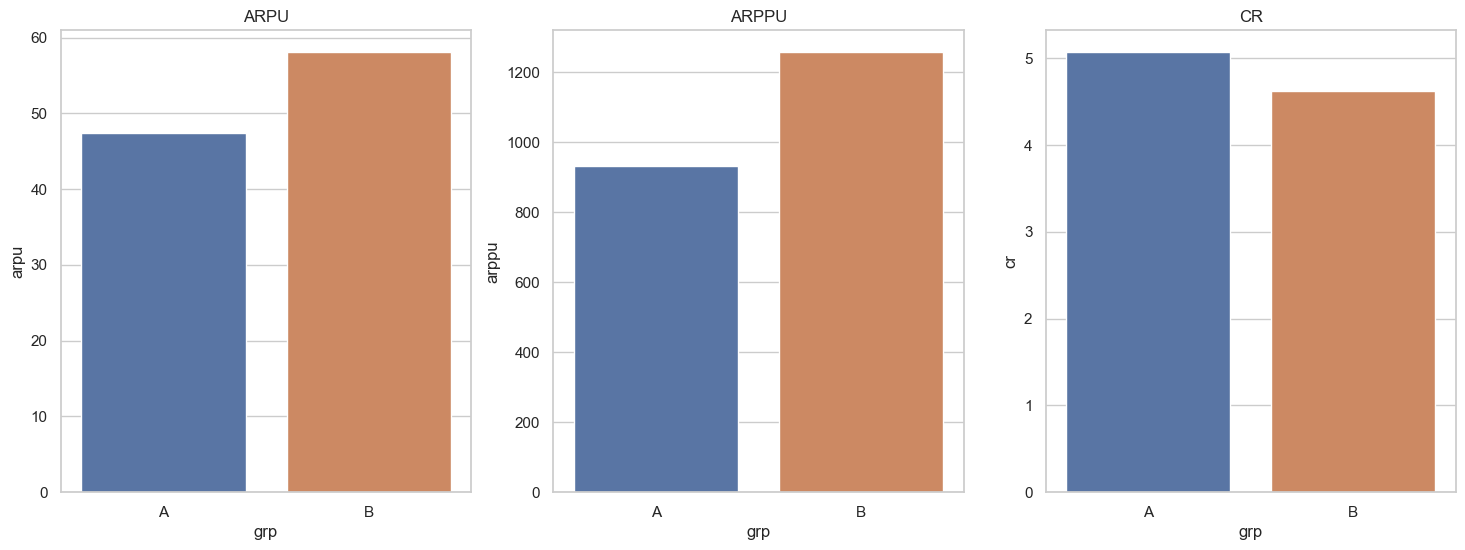

In [71]:
graphs(result)